In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from pathlib import Path
import math, pandas as pd, numpy as np
print("=== CELL 1: DRY-RUN (compute multipliers & preview) ===")

# --- Edit if your Drive layout differs ---
DRIVE_MOUNT = Path("/content/drive")
DRIVE_ROOT = DRIVE_MOUNT / "MyDrive" / "eye_project"
SPLITS_DIR = DRIVE_ROOT / "processed" / "splits_strict_10cls_new"
TRAIN_CSV = SPLITS_DIR / "train.csv"

# --- Policy params (final) ---
MEDIAN_MULT = 1.5
MAX_MULT = 3
MIN_MULT = 1
IMG_SIZE = (320,320)
# final variant mapping (you approved ±9°)
def variants_for_k(k):
    if k == 1:
        return ["orig"]
    if k == 2:
        return ["orig", "rot+9"]
    if k >= 3:
        return ["orig", "rot+9", "rot-9"]
    return ["orig"]

DRY_RUN = True  # DO NOT CHANGE for this cell

# 1) Mount Drive (Colab)
try:
    from google.colab import drive
    drive.mount(str(DRIVE_MOUNT), force_remount=False)
    print("Drive mount OK:", DRIVE_MOUNT)
except Exception as e:
    print("Note: google.colab.drive not available (are you running locally?):", e)

# 2) Check CSV exists
if not TRAIN_CSV.exists():
    raise FileNotFoundError(f"Train CSV not found: {TRAIN_CSV}\nCheck path: {SPLITS_DIR}")

print("Found train CSV:", TRAIN_CSV)
train_df = pd.read_csv(TRAIN_CSV)
print("Rows in train CSV:", len(train_df))
print("Columns:", list(train_df.columns))

# 3) Basic columns
IMG_COL = "img_path"
LBL_COL = "label"
if IMG_COL not in train_df.columns or LBL_COL not in train_df.columns:
    raise RuntimeError(f"Expected columns '{IMG_COL}' and '{LBL_COL}' in train CSV")

# 4) Normalize img_path (ensure they point under Drive root if stored that way)
def to_drive_prefix(p):
    s = str(p)
    if s.startswith("/content/drive/MyDrive"):
        return s
    if s.startswith(str(DRIVE_ROOT)):
        return s
    return s
train_df[IMG_COL] = train_df[IMG_COL].astype(str).apply(to_drive_prefix)

# 5) Compute counts and per-class k
counts = train_df[LBL_COL].value_counts().sort_index()
classes = counts.index.tolist()
orig_counts = counts.to_dict()
median_count = int(np.median(list(orig_counts.values())))
target_per_class = math.ceil(median_count * MEDIAN_MULT)

per_class_k = {}
final_counts = {}
for c in classes:
    n = orig_counts[c]
    k = math.ceil(target_per_class / max(1, n))
    k = int(max(MIN_MULT, min(k, MAX_MULT)))
    per_class_k[c] = k
    final_counts[c] = n * k

total_orig = sum(orig_counts.values())
total_final = sum(final_counts.values())
total_added = total_final - total_orig

# 6) Print plan
print("\nPolicy settings:")
print(f"  median_count = {median_count}")
print(f"  target_per_class = ceil(median * {MEDIAN_MULT}) = {target_per_class}")
print(f"  clamped k in [1, {MAX_MULT}]\n")

rows = []
for c in classes:
    rows.append({
        "class": c,
        "orig": orig_counts[c],
        "k": per_class_k[c],
        "final_count": final_counts[c],
        "added": final_counts[c] - orig_counts[c],
        "pct_increase": (final_counts[c] - orig_counts[c]) / orig_counts[c] * 100.0 if orig_counts[c] > 0 else None,
        "variants_for_k": variants_for_k(per_class_k[c])
    })
table = pd.DataFrame(rows).set_index("class")
display(table)

print(f"TOTAL — orig: {total_orig}  final: {total_final}  added: {total_added}  overall%inc: {total_added/total_orig*100:.1f}%\n")

# 7) Sample image path check (up to 3 per class)
print("Sample image paths (up to 3 per class) and existence check:")
sample_rows = []
for c in classes:
    paths = train_df[train_df[LBL_COL]==c][IMG_COL].drop_duplicates().tolist()[:3]
    for p in paths:
        sample_rows.append((c, p, Path(p).exists()))
sample_df = pd.DataFrame(sample_rows, columns=["class","sample_img_path","exists"])
display(sample_df)

# 8) Manifest preview summary
manifest_preview = []
for c in classes:
    manifest_preview.append({"class": c, "orig_count": orig_counts[c], "k": per_class_k[c], "variants": variants_for_k(per_class_k[c])})
display(pd.DataFrame(manifest_preview))


# ================= end CELL 1 =================


=== CELL 1: DRY-RUN (compute multipliers & preview) ===
Mounted at /content/drive
Drive mount OK: /content/drive
Found train CSV: /content/drive/MyDrive/eye_project/processed/splits_strict_10cls_new/train.csv
Rows in train CSV: 768
Columns: ['UID', 'ID', 'source', 'label', 'AION', 'ARMD', 'BRVO', 'CRVO', 'DR', 'MHL', 'ERM', 'ODC', 'RPEC', 'DN', 'img_path']

Policy settings:
  median_count = 43
  target_per_class = ceil(median * 1.5) = 65
  clamped k in [1, 3]



,orig,k,final_count,added,pct_increase,variants_for_k
class,,,,,,
AION,15,3,45,30,200.0,"[orig, rot+9, rot-9]"
ARMD,52,2,104,52,100.0,"[orig, rot+9]"
BRVO,69,1,69,0,0.0,[orig]
CRVO,35,2,70,35,100.0,"[orig, rot+9]"
DN,111,1,111,0,0.0,[orig]
DR,329,1,329,0,0.0,[orig]
ERM,11,3,33,22,200.0,"[orig, rot+9, rot-9]"
MHL,8,3,24,16,200.0,"[orig, rot+9, rot-9]"
ODC,120,1,120,0,0.0,[orig]


TOTAL — orig: 768  final: 959  added: 191  overall%inc: 24.9%

Sample image paths (up to 3 per class) and existence check:


,class,sample_img_path,exists
0,AION,/content/drive/MyDrive/eye_project/raw/RFMiD/T...,True
1,AION,/content/drive/MyDrive/eye_project/raw/RFMiD2_...,True
2,AION,/content/drive/MyDrive/eye_project/raw/RFMiD/T...,True
3,ARMD,/content/drive/MyDrive/eye_project/raw/RFMiD/T...,True
4,ARMD,/content/drive/MyDrive/eye_project/raw/RFMiD/T...,True
5,ARMD,/content/drive/MyDrive/eye_project/raw/RFMiD/T...,True
6,BRVO,/content/drive/MyDrive/eye_project/raw/RFMiD/E...,True
7,BRVO,/content/drive/MyDrive/eye_project/raw/RFMiD/T...,True
8,BRVO,/content/drive/MyDrive/eye_project/raw/RFMiD/T...,True
9,CRVO,/content/drive/MyDrive/eye_project/raw/RFMiD/T...,True


,class,orig_count,k,variants
0,AION,15,3,"[orig, rot+9, rot-9]"
1,ARMD,52,2,"[orig, rot+9]"
2,BRVO,69,1,[orig]
3,CRVO,35,2,"[orig, rot+9]"
4,DN,111,1,[orig]
5,DR,329,1,[orig]
6,ERM,11,3,"[orig, rot+9, rot-9]"
7,MHL,8,3,"[orig, rot+9, rot-9]"
8,ODC,120,1,[orig]
9,RPEC,18,3,"[orig, rot+9, rot-9]"


# ============================================
# 📌  DATASET + TRANSFORMS + LOADERS
# ============================================

In [ ]:


import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import pandas as pd
from pathlib import Path

# -----------------------------------------
# Load CSVs
# -----------------------------------------
ROOT = Path("/content/drive/MyDrive/eye_project")
PROC = ROOT / "processed"

train_aug_csv = PROC / "train_augmented.csv"   # NEW augmented CSV
val_csv       = PROC / "splits_strict_10cls_new" / "val.csv"

train_df = pd.read_csv(train_aug_csv)
val_df   = pd.read_csv(val_csv)

print("Loaded augmented train:", train_df.shape)
print("Loaded val:", val_df.shape)

# -----------------------------------------
# CLASS ORDER (same as your model)
# -----------------------------------------
CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASSES)}

# -----------------------------------------
# TRANSFORMS (online preprocessing)
# -----------------------------------------
# Recommended size: 384×384 (RFMiD images are large)
IMG_SIZE = 384

train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(20),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# -----------------------------------------
# DATASET CLASS
# -----------------------------------------
class EyeDiseaseDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = row["img_path"]
        label = CLASS_TO_IDX[row["label"]]

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        return img, label

# -----------------------------------------
# Create datasets
# -----------------------------------------
train_dataset = EyeDiseaseDataset(train_df, train_transform)
val_dataset   = EyeDiseaseDataset(val_df, val_transform)

# -----------------------------------------
# Create dataloaders
# -----------------------------------------
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("\nDataset + DataLoader ready.")
print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Loaded augmented train: (959, 2)
Loaded val: (165, 15)

Dataset + DataLoader ready.
Train batches: 30
Val batches: 6


# ============================================
# 📌 MODEL + LOSS + OPTIMIZER (50 epochs)
# ============================================

In [ ]:


import torch
import torch.nn as nn
import torchvision.models as models

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# -----------------------------------------
# Load pretrained ResNet34
# -----------------------------------------
model = models.resnet34(weights="IMAGENET1K_V1")

# Replace final FC layer (512 -> NUM_CLASSES)
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.fc.in_features, 10)
)

model = model.to(DEVICE)
print("\nModel ready with dropout head.")

# -----------------------------------------
# LOSS with label smoothing
# -----------------------------------------
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# -----------------------------------------
# Optimizer (AdamW)
# -----------------------------------------
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

# -----------------------------------------
# OneCycleLR Scheduler
# -----------------------------------------
EPOCHS = 50   # <--- UPDATED HERE

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=3e-4,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS
)

print("Optimizer + Scheduler ready. Training for 50 epochs.")


Device: cuda
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 208MB/s]



Model ready with dropout head.
Optimizer + Scheduler ready. Training for 50 epochs.


# ============================================
# 📌 TRAINING + VALIDATION LOOP
# ============================================

In [ ]:


import torch
import torch.nn.functional as F
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


def validate_one_epoch(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validating", leave=False):
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


# -----------------------------------------
# Training Loop
# -----------------------------------------
best_val_acc = 0
history = []

print("\n🚀 Starting training...\n")

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scheduler)
    val_loss, val_acc     = validate_one_epoch(model, val_loader)

    history.append((train_loss, train_acc, val_loss, val_acc))

    print(f"Epoch {epoch+1}/{EPOCHS}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/content/best_resnet34.pth")

print("\n🎉 Training complete!")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")



🚀 Starting training...



Epoch 1/50: Train Loss=2.2992, Train Acc=0.1804 | Val Loss=1.8458, Val Acc=0.5030


Epoch 2/50: Train Loss=1.8896, Train Acc=0.4067 | Val Loss=1.5290, Val Acc=0.6121


Epoch 3/50: Train Loss=1.5323, Train Acc=0.5589 | Val Loss=1.2958, Val Acc=0.6848


Epoch 4/50: Train Loss=1.2494, Train Acc=0.6924 | Val Loss=1.1878, Val Acc=0.7576


Epoch 5/50: Train Loss=1.0520, Train Acc=0.7716 | Val Loss=1.1094, Val Acc=0.7394


Epoch 6/50: Train Loss=0.9009, Train Acc=0.8405 | Val Loss=1.1334, Val Acc=0.6970


Epoch 7/50: Train Loss=0.7953, Train Acc=0.8895 | Val Loss=1.1788, Val Acc=0.7394


Epoch 8/50: Train Loss=0.7910, Train Acc=0.8999 | Val Loss=1.2370, Val Acc=0.7455


Epoch 9/50: Train Loss=0.7777, Train Acc=0.9082 | Val Loss=1.3190, Val Acc=0.6667


Epoch 10/50: Train Loss=0.7717, Train Acc=0.8978 | Val Loss=1.3170, Val Acc=0.7455


Epoch 11/50: Train Loss=0.7670, Train Acc=0.9041 | Val Loss=1.2130, Val Acc=0.7576


Epoch 12/50: Train Loss=0.7665, Train Acc=0.9062 | Val Loss=1.5206, Val Acc=0.6909


Epoch 13/50: Train Loss=0.6989, Train Acc=0.9437 | Val Loss=1.2375, Val Acc=0.7273


Epoch 14/50: Train Loss=0.6888, Train Acc=0.9416 | Val Loss=1.1260, Val Acc=0.7939


Epoch 15/50: Train Loss=0.6885, Train Acc=0.9520 | Val Loss=1.6189, Val Acc=0.6303


Epoch 16/50: Train Loss=0.6682, Train Acc=0.9499 | Val Loss=1.0241, Val Acc=0.8061


Epoch 17/50: Train Loss=0.6614, Train Acc=0.9520 | Val Loss=1.1397, Val Acc=0.7758


Epoch 18/50: Train Loss=0.6269, Train Acc=0.9656 | Val Loss=1.1073, Val Acc=0.7697


Epoch 19/50: Train Loss=0.6461, Train Acc=0.9604 | Val Loss=1.1290, Val Acc=0.7636


Epoch 20/50: Train Loss=0.5821, Train Acc=0.9896 | Val Loss=1.0439, Val Acc=0.7697


Epoch 21/50: Train Loss=0.5616, Train Acc=0.9958 | Val Loss=1.0310, Val Acc=0.7758


Epoch 22/50: Train Loss=0.5600, Train Acc=0.9969 | Val Loss=1.2040, Val Acc=0.7515


Epoch 23/50: Train Loss=0.5511, Train Acc=1.0000 | Val Loss=0.9772, Val Acc=0.8242


Epoch 24/50: Train Loss=0.5469, Train Acc=0.9958 | Val Loss=1.0400, Val Acc=0.7818


Epoch 25/50: Train Loss=0.5527, Train Acc=0.9937 | Val Loss=1.0420, Val Acc=0.8182


Epoch 26/50: Train Loss=0.5626, Train Acc=0.9885 | Val Loss=0.9717, Val Acc=0.8182


Epoch 27/50: Train Loss=0.5471, Train Acc=0.9958 | Val Loss=1.0189, Val Acc=0.7697


Epoch 28/50: Train Loss=0.5333, Train Acc=1.0000 | Val Loss=0.9700, Val Acc=0.8000


Epoch 29/50: Train Loss=0.5309, Train Acc=1.0000 | Val Loss=0.9722, Val Acc=0.8000


Epoch 30/50: Train Loss=0.5360, Train Acc=0.9969 | Val Loss=0.9868, Val Acc=0.7939


Epoch 31/50: Train Loss=0.5383, Train Acc=0.9969 | Val Loss=0.9564, Val Acc=0.8242


Epoch 32/50: Train Loss=0.5301, Train Acc=1.0000 | Val Loss=0.9952, Val Acc=0.8182


Epoch 33/50: Train Loss=0.5299, Train Acc=1.0000 | Val Loss=0.9720, Val Acc=0.8182


Epoch 34/50: Train Loss=0.5279, Train Acc=1.0000 | Val Loss=0.9835, Val Acc=0.7939


Epoch 35/50: Train Loss=0.5277, Train Acc=0.9990 | Val Loss=0.9816, Val Acc=0.8000


Epoch 36/50: Train Loss=0.5269, Train Acc=0.9990 | Val Loss=0.9750, Val Acc=0.8242


Epoch 37/50: Train Loss=0.5244, Train Acc=1.0000 | Val Loss=0.9925, Val Acc=0.8182


Epoch 38/50: Train Loss=0.5244, Train Acc=0.9990 | Val Loss=0.9616, Val Acc=0.8182


Epoch 39/50: Train Loss=0.5219, Train Acc=1.0000 | Val Loss=0.9857, Val Acc=0.8121


Epoch 40/50: Train Loss=0.5209, Train Acc=1.0000 | Val Loss=0.9827, Val Acc=0.8182


Epoch 41/50: Train Loss=0.5221, Train Acc=0.9990 | Val Loss=0.9740, Val Acc=0.8121


Epoch 42/50: Train Loss=0.5190, Train Acc=1.0000 | Val Loss=0.9927, Val Acc=0.7939


Epoch 43/50: Train Loss=0.5208, Train Acc=1.0000 | Val Loss=0.9792, Val Acc=0.7939


Epoch 44/50: Train Loss=0.5207, Train Acc=1.0000 | Val Loss=0.9794, Val Acc=0.8061


Epoch 45/50: Train Loss=0.5230, Train Acc=0.9990 | Val Loss=0.9659, Val Acc=0.8061


Epoch 46/50: Train Loss=0.5203, Train Acc=1.0000 | Val Loss=0.9620, Val Acc=0.8121


Epoch 47/50: Train Loss=0.5209, Train Acc=1.0000 | Val Loss=0.9676, Val Acc=0.8061


Epoch 48/50: Train Loss=0.5193, Train Acc=1.0000 | Val Loss=0.9630, Val Acc=0.8061


Epoch 49/50: Train Loss=0.5197, Train Acc=1.0000 | Val Loss=0.9572, Val Acc=0.8182


Epoch 50/50: Train Loss=0.5184, Train Acc=1.0000 | Val Loss=0.9601, Val Acc=0.8121

🎉 Training complete!
Best Validation Accuracy: 0.8242


In [ ]:
from pathlib import Path
import torch

# Create folder: /content/drive/MyDrive/eye_project/aug_models/
AUG_MODEL_DIR = Path("/content/drive/MyDrive/eye_project/aug_models")
AUG_MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Save best model to this folder
save_path = AUG_MODEL_DIR / "Final_best_resnet34_augmented.pth"
torch.save(model.state_dict(), save_path)

print("✅ Saved best model to:", save_path)


✅ Saved best model to: /content/drive/MyDrive/eye_project/aug_models/Final_best_resnet34_augmented.pth


# ============================================
# 📌TRAINING ACCURACY & LOSS CURVES
# ============================================

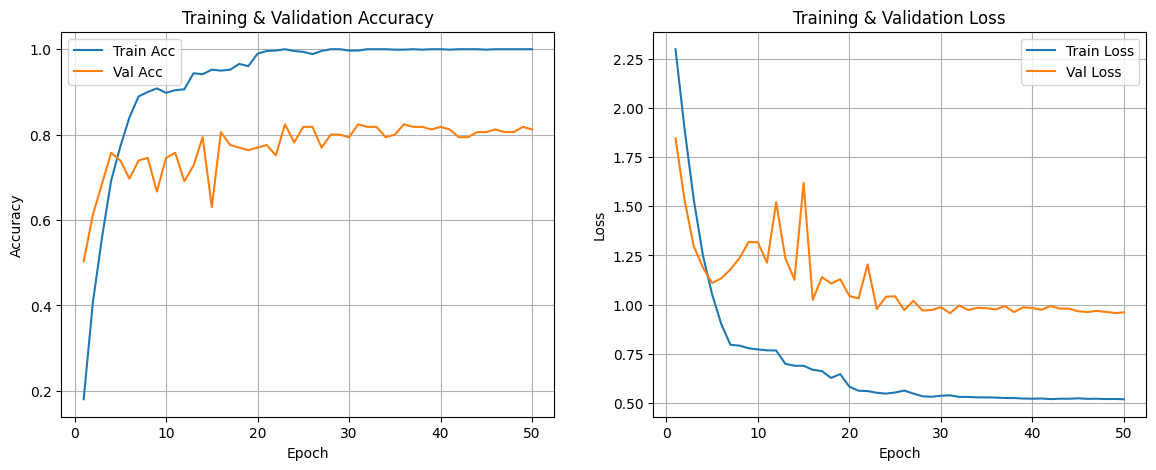

In [ ]:
import matplotlib.pyplot as plt

train_loss = [h[0] for h in history]
train_acc  = [h[1] for h in history]
val_loss   = [h[2] for h in history]
val_acc    = [h[3] for h in history]

epochs = range(1, len(history)+1)

plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

plt.show()


# ============================================
# 📌LOAD BEST MODEL & PREPARE TEST LOADER
# ============================================

In [ ]:
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import torchvision.transforms as T

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# paths
ROOT = Path("/content/drive/MyDrive/eye_project")
PROC = ROOT / "processed"
TEST_CSV = PROC / "splits_strict_10cls_new" / "test.csv"

# load test dataframe
test_df = pd.read_csv(TEST_CSV)

# fix img_path for colab (if needed)
test_df['img_path'] = test_df['img_path'].str.replace(
    "G:/My Drive/eye_project",
    "/content/drive/MyDrive/eye_project"
)

# same classes & transform as before
CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASSES)}

IMG_SIZE = 384
test_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# dataset class
class EyeDiseaseDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img = Image.open(row["img_path"]).convert("RGB")
        label = CLASS_TO_IDX[row["label"]]
        return self.transform(img), label

test_dataset = EyeDiseaseDataset(test_df, test_transform)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# load model
import torchvision.models as models
import torch.nn as nn

model = models.resnet34(weights="IMAGENET1K_V1")
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.fc.in_features, 10)
)
model = model.to(DEVICE)

# load best weights
MODEL_PATH = ROOT / "aug_models" / "Final_best_resnet34_augmented.pth"
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

print("✅ Best model loaded from:", MODEL_PATH)
print("Test loader ready with", len(test_loader), "batches.")


✅ Best model loaded from: /content/drive/MyDrive/eye_project/aug_models/Final_best_resnet34_augmented.pth
Test loader ready with 6 batches.


# ============================================
# 📌 CONFUSION MATRIX & CLASSIFICATION REPORT (TEST)
# ============================================

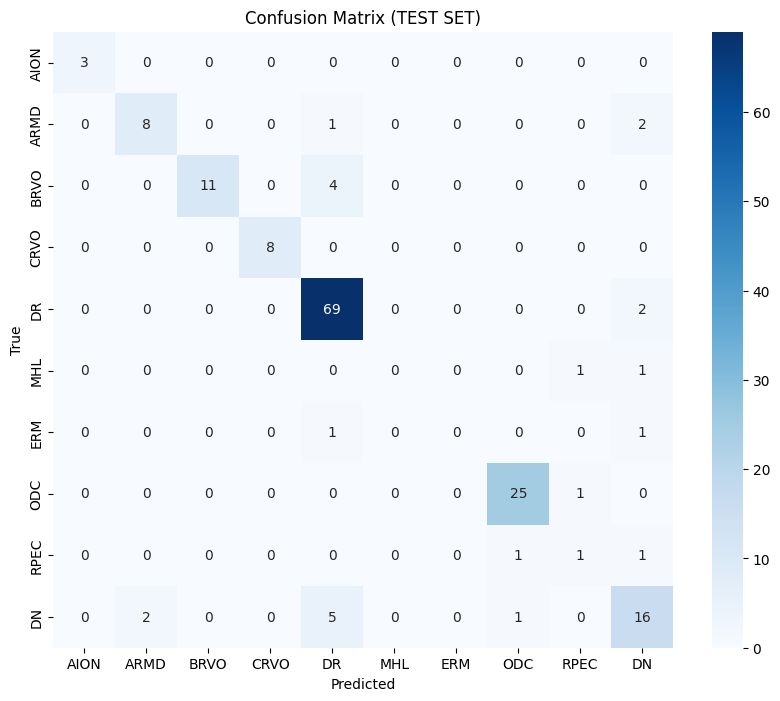


📌 Classification Report (TEST SET):

              precision    recall  f1-score   support

        AION       1.00      1.00      1.00         3
        ARMD       0.80      0.73      0.76        11
        BRVO       1.00      0.73      0.85        15
        CRVO       1.00      1.00      1.00         8
          DR       0.86      0.97      0.91        71
         MHL       0.00      0.00      0.00         2
         ERM       0.00      0.00      0.00         2
         ODC       0.93      0.96      0.94        26
        RPEC       0.33      0.33      0.33         3
          DN       0.70      0.67      0.68        24

    accuracy                           0.85       165
   macro avg       0.66      0.64      0.65       165
weighted avg       0.84      0.85      0.84       165



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

true_labels = []
pred_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    cmap="Blues"
)
plt.title("Confusion Matrix (TEST SET)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("\n📌 Classification Report (TEST SET):\n")
print(classification_report(true_labels, pred_labels, target_names=CLASSES))


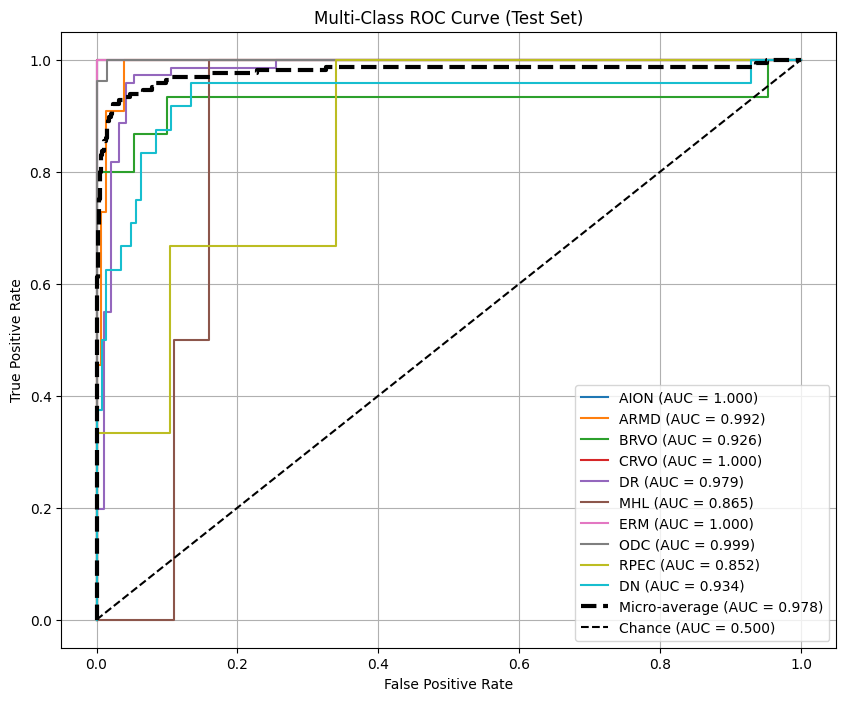

In [ ]:
# ============================================
# 📌 MULTI-CLASS AUC ROC CURVE
# ============================================

import torch
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model.eval()

all_probs = []
all_labels = []

# --- Collect probabilities and true labels ---
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)

        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()

        all_probs.append(probs)
        all_labels.append(labels.numpy())

# Convert lists to arrays
all_probs = np.concatenate(all_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# --- One-hot encode labels ---
y_onehot = label_binarize(all_labels, classes=list(range(len(CLASSES))))

# --- Compute ROC curve and AUC for each class ---
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))

for i in range(len(CLASSES)):
    fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    plt.plot(
        fpr[i],
        tpr[i],
        label=f"{CLASSES[i]} (AUC = {roc_auc[i]:.3f})"
    )

# --- Micro-average ---
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.plot(
    fpr["micro"],
    tpr["micro"],
    linestyle='--',
    linewidth=3,
    color='black',
    label=f"Micro-average (AUC = {roc_auc['micro']:.3f})"
)

# --- ADD DIAGONAL BASELINE ---
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.500)")

plt.title("Multi-Class ROC Curve (Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
import gradio as gr
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np

# --- Load Model ---
import torchvision.models as models
import torch.nn as nn

MODEL_PATH = "/content/drive/MyDrive/eye_project/aug_models/Final_best_resnet34_augmented.pth"

CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# load resnet34
model = models.resnet34(weights=None)
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(512, len(CLASSES))
)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# --- Test-time augmentation transforms ---
def tta_predict(img):
    tta_transforms = [
        T.Compose([
            T.Resize((384,384)),
            T.ToTensor(),
            T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        ]),
        T.Compose([
            T.Resize((384,384)),
            T.RandomHorizontalFlip(p=1.0),
            T.ToTensor(),
            T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        ]),
        T.Compose([
            T.Resize((384,384)),
            T.RandomRotation(10),
            T.ToTensor(),
            T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        ]),
    ]

    preds = []
    for tf in tta_transforms:
        t = tf(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out = model(t)
            prob = torch.softmax(out, dim=1)
        preds.append(prob)

    final = torch.stack(preds).mean(dim=0)
    return final.cpu().numpy()[0]


# --- Gradio prediction function ---
def classify_fundus(image):
    img = Image.fromarray(image).convert("RGB")

    probs = tta_predict(img)
    pred_idx = np.argmax(probs)
    pred_label = CLASSES[pred_idx]
    confidence = float(probs[pred_idx])

    # Make readable probability table
    prob_table = {CLASSES[i]: float(probs[i]) for i in range(len(CLASSES))}

    return pred_label, confidence, prob_table


# --- Launch UI ---
interface = gr.Interface(
    fn=classify_fundus,
    inputs=gr.Image(label="Upload Fundus Image"),
    outputs=[
        gr.Label(label="Predicted Disease"),
        gr.Number(label="Confidence"),
        gr.JSON(label="Class Probabilities")
    ],
    title="Fundus Disease Classifier (ResNet34 + TTA)",
    description="Upload a fundus image to classify into 10 disease categories."
)

interface.launch(debug=False)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c83a8525fe85e2665d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
